In [1]:
import pandas as pd
import numpy as np
import sys, os
import pickle
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
df = pd.read_csv("./dataset/new_bgg_data_after_eda2.csv",encoding="utf-8")
df.drop(columns = ["Rank", "Id", "Name"], inplace = True)

In [3]:
df_ = df.copy()

In [4]:
#from previous notebook

# Year
df_v1 = df_.copy()
before = df_.shape[0]
df_v1.drop(index = df_v1[df_v1.Year < 1600].index, inplace=True)
after = df_v1.shape[0]
print (f"By year, we drop {before - after} entries.")

# MaxPlayer
df_v2 = df_v1.copy() 
before = df_v1.shape[0]
df_v2.drop(index = df_v2[df_v2.Maxplayers > 20].index, inplace=True)
after = df_v2.shape[0]
print (f"By Max Player, we drop {before - after} entries.")

# drop artist
df_v3 = df_v2.copy() 
df_v3.drop(columns="Nartist", inplace=True)

By year, we drop 202 entries.
By Max Player, we drop 244 entries.


## Problem 2.

In [5]:
test_size = 0.2
random_state = 42
target_ = "Rating"
unused_feature_list_ = ["Own", "Users_rated"]

In [6]:
from sklearn.model_selection import train_test_split

def get_Xs_Ys(df, target = target_, exclude = unused_feature_list_, use_val=True):

      assert type(exclude) == list, "exclude must be list"

      train, test = train_test_split(
                        df,
                        test_size = test_size,
                        random_state = random_state)
      if use_val:
            train, val = train_test_split(
                              train,
                              test_size = test_size,
                              random_state = random_state)


      get_y = lambda data : data[target]
      get_x = lambda data : data.drop(columns = [target] + exclude)

      Ys = {"train" : get_y(train),
            "test" : get_y(test)}
      Xs = {"train" : get_x(train),
            "test" : get_x(test)}
      
      if use_val:
            Ys['val'] = get_y(val)
            Xs['val'] = get_x(val)
            
      return Xs, Ys
        
Xs, Ys = get_Xs_Ys(df)

In [7]:
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

def make_xgb(xgb_args={}):
    
    xgb_args["n_estimators"] = int(xgb_args["n_estimators"])
    xgb_args["max_depth"] = int(xgb_args["max_depth"])
    
    return XGBRegressor(random_state=random_state,
                          n_jobs=-1,
                          tree_method = 'gpu_hist',
                          early_stopping_rounds=10,
                          gpu_id=0,
                          **xgb_args)
    

def find_best_param_xgb(df, results=False):
    
    params = {
        "n_estimators" : hp.quniform("n_estimators", 100, 2000, 100),
        "learning_rate" : hp.uniform("learning_rate", 0.001, 1.0),
        "max_depth": hp.quniform("max_depth", 2, 20, 2),
        "min_child_weight" : hp.uniform("min_child_weight", 0., 2.),
        "gamma" : hp.uniform("gamma", 0.0, 1.),
        "subsample" : hp.uniform("subsample", 0.5, 1.),
        "colsample_bytree" : hp.uniform("colsample_bytree", 0.5, 1.),
        "lambda" : hp.uniform("lambda", 0.1, 10.),
        "alpha" : hp.uniform("alpha", 0., 10.),
    } 
    Xs, Ys = get_Xs_Ys(df, use_val=True)
    
    
    def fit_and_eval(params):
    
        xgb = make_xgb(xgb_args = params)
        
        xgb.fit(Xs['train'], Ys['train'], verbose=False,
                eval_set = [(Xs['train'],Ys['train']), (Xs['val'], Ys['val'])])
        
        y_pred_val = xgb.predict(Xs['val'])
        
        score = mean_squared_error(Ys['val'], y_pred_val)
                
        return {"loss" : score, "status":STATUS_OK}
    

    trials = (Trials())       
    
    best_params = fmin(
        fn = fit_and_eval,
        trials = trials,
        space = params,
        algo = tpe.suggest,
        max_evals = 10
    )

    if results:
        return best_params, trials

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_models(y_pred, y_true, verbose = False):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    if verbose:
        
        return {"MSE" : mse,
                "RMSE" : rmse,
                "MAE" : mae,
                "R2": r2}
    else:
        return mse, rmse, mae, r2

def test_eval(x_test, y_test, model):

    eval_test = eval_models(model.predict(x_test), y_test)

    return pd.DataFrame(eval_test, index=["MSE", "RMSE", "MAE", "R2"], columns=[y_test.name]).T

In [9]:
def make_best_model(param, Xs, Ys):

    xgb = make_xgb(xgb_args=param)
    xgb.fit(Xs['train'], Ys['train'], verbose=False,
            eval_set = [(Xs['train'],Ys['train']),
                        (Xs['val'], Ys['val'])])
   
    return xgb


In [10]:
dataset = [df_, df_v1, df_v2, df_v3]
# dataset = [df_]

best_params_group = []
trials_group = []

for data in dataset:
    best_params, trials = find_best_param_xgb(data, results= True)
    best_params_group.append(best_params)
    trials_group.append(trials)

100%|██████████| 10/10 [00:11<00:00,  1.14s/trial, best loss: 0.3963364704323121]


In [11]:
Xs, Ys = get_Xs_Ys(df_v1)
# Xs, Ys = get_Xs_Ys(df)
best_xgb = make_best_model(best_params_group[1], Xs, Ys)


In [12]:
test_eval(Xs['test'], Ys['test'], best_xgb)

,MSE,RMSE,MAE,R2
Rating,0.345046,0.587406,0.433833,0.583158


In [13]:
import eli5
from eli5.sklearn import PermutationImportance

In [14]:
def perm_imp(model, x_val, y_val, results=False):
    permuter = PermutationImportance(
                model,
                scoring = "r2",
                n_iter = 10,
                random_state = random_state)

    permuter.fit(x_val, y_val);
    
    feature_names = x_val.columns.tolist()
    pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
    
    pi.tail(20).plot.barh()
    plt.rcParams['font.family'] = 'Malgun Gothic'   
    plt.title(f"Permutation Importance Top 20 for {y_val.name} ")
    plt.show()
    
    if results:
        return pi.tail(20).index

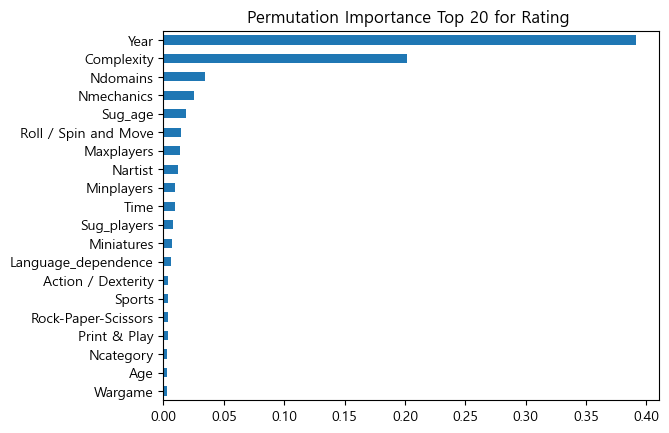

In [15]:
features = perm_imp(best_xgb, Xs['val'], Ys['val'], results=True)

In [16]:
from pdpbox.pdp import pdp_isolate, pdp_plot

def get_iso_pdp_plot(target_feature, model, x_test, plot_point = 10, range_ =None):
    plt.rcParams["figure.dpi"] = 144

    isolated = pdp_isolate(
        model = model,
        dataset = x_test,
        model_features=x_test.columns,
        feature=target_feature,
        grid_type = "percentile",
        num_grid_points = 20,
        percentile_range = range_,
        
    )
    pdp_plot(isolated, feature_name = target_feature,
             frac_to_plot = plot_point,
             plot_lines=True,
             plot_pts_dist=True)

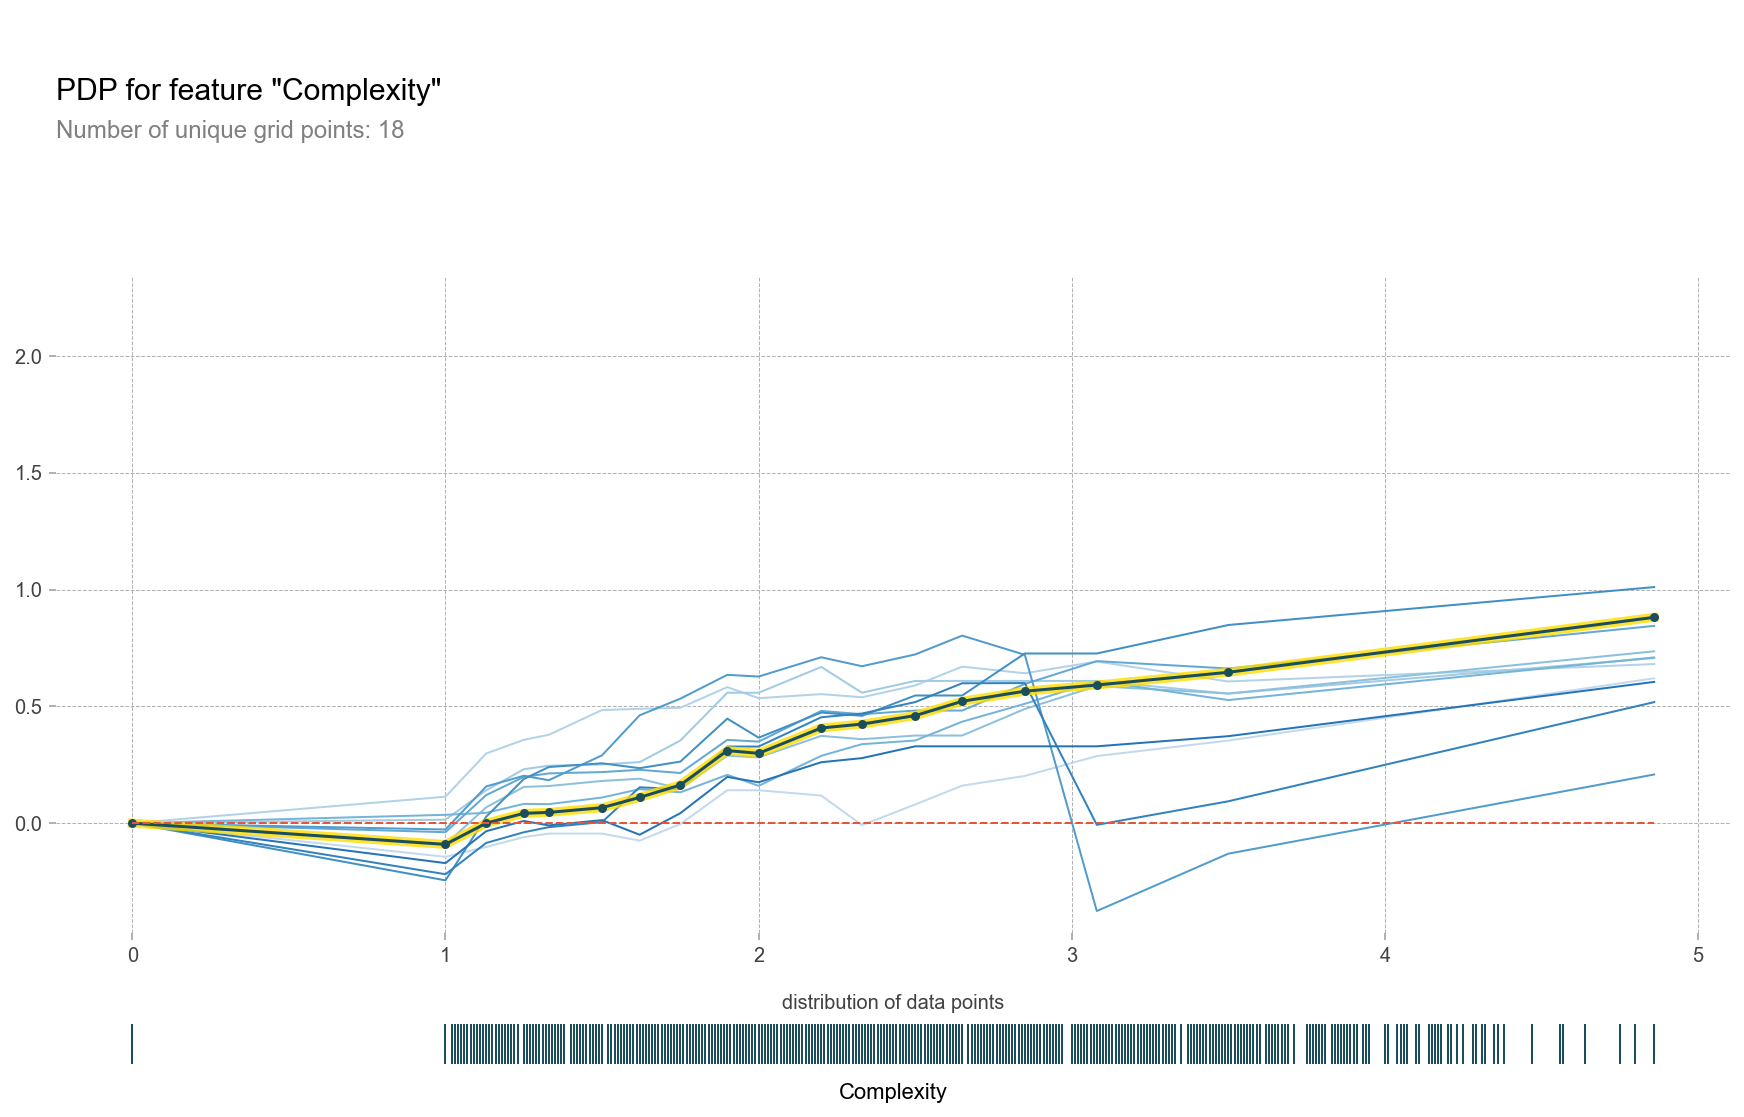

In [17]:
get_iso_pdp_plot("Complexity", best_xgb, Xs['val'])

In [18]:
df_["Language_dependence"].isna().sum()

4662

In [19]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

def get_inter_pdp_plot(target_feature1, target_feature2, model, x_test):

    target_features = [target_feature1, target_feature2]

    interaction = pdp_interact(
        model = model,
        dataset = x_test,
        model_features=x_test.columns,
        features = target_features,
    )

    pdp_interact_plot(interaction, plot_type="grid", feature_names = target_features)

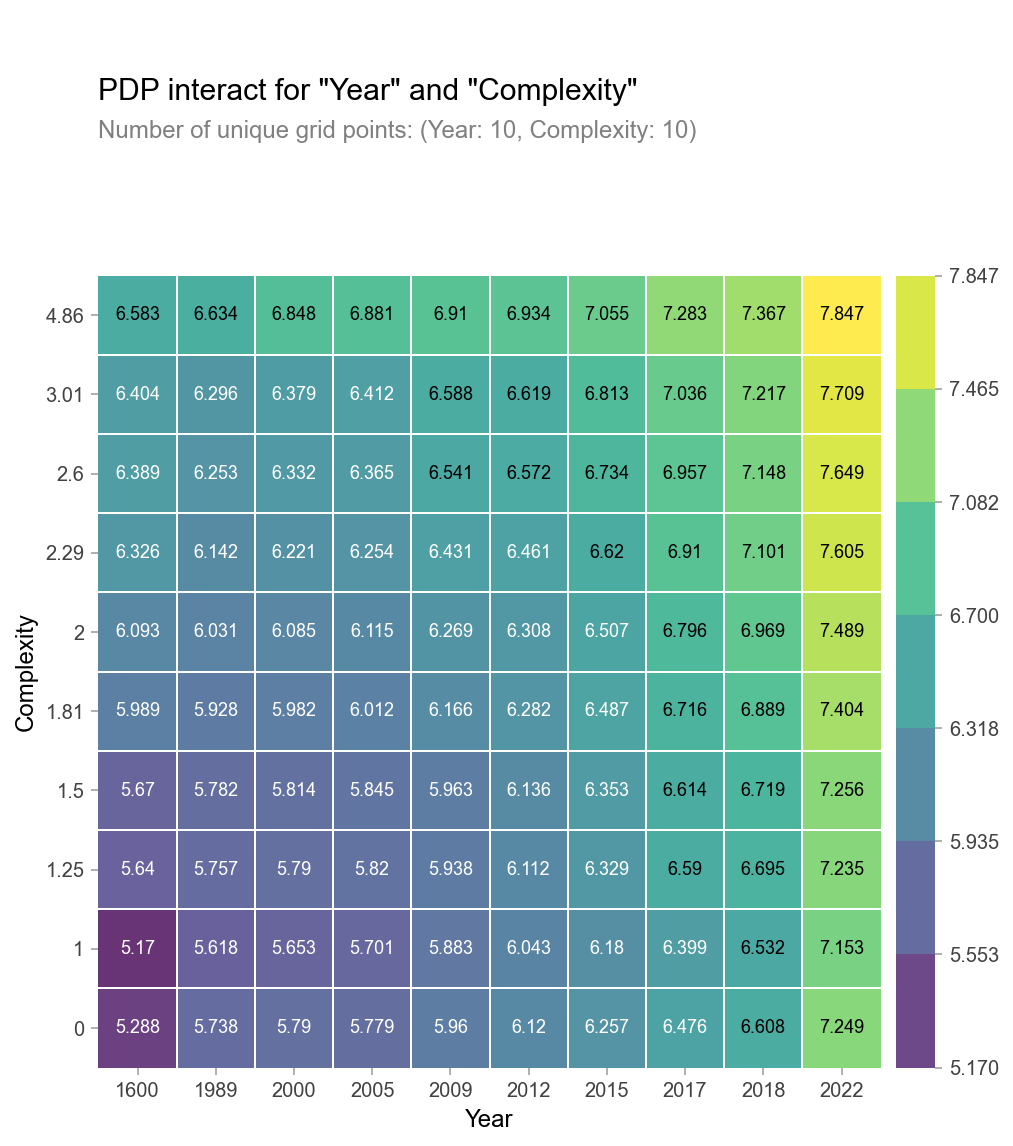

In [20]:
get_inter_pdp_plot("Year", "Complexity", best_xgb, Xs['val'])

if we drop Year?

In [21]:
df.drop(columns = ["Year"], inplace = True)

Xs, Ys = get_Xs_Ys(df)
best_params, trials = find_best_param_xgb(df, results= True)
best_xgb_ = make_best_model(best_params, Xs, Ys)
test_eval(Xs['test'], Ys['test'], best_xgb_)

100%|██████████| 10/10 [00:14<00:00,  1.48s/trial, best loss: 0.4201506547861346]


,MSE,RMSE,MAE,R2
Rating,0.438076,0.661873,0.495909,0.488101


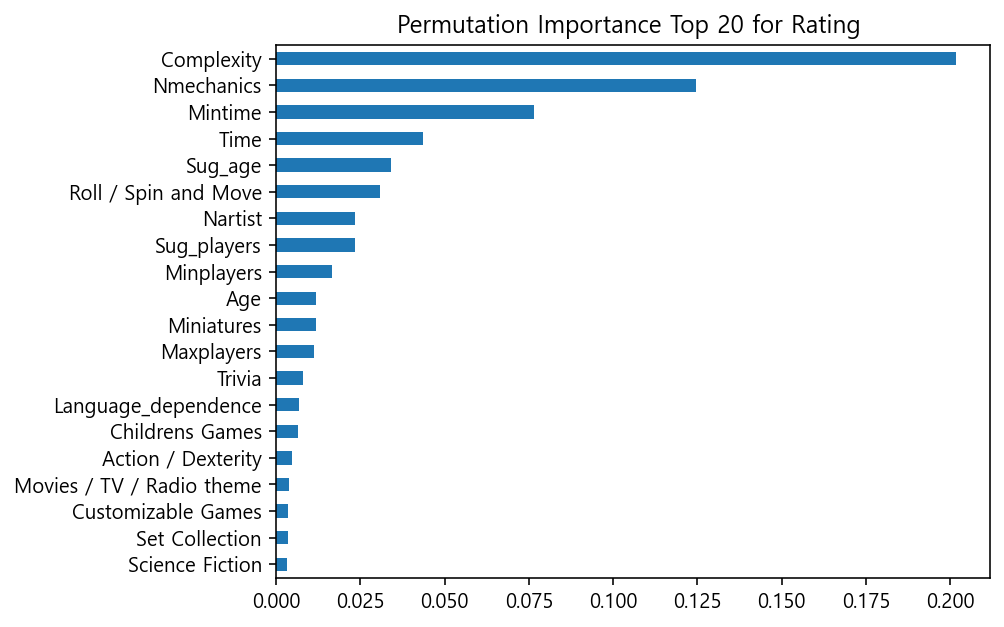

In [22]:
features_ = perm_imp(best_xgb_, Xs['val'], Ys['val'], results=True)

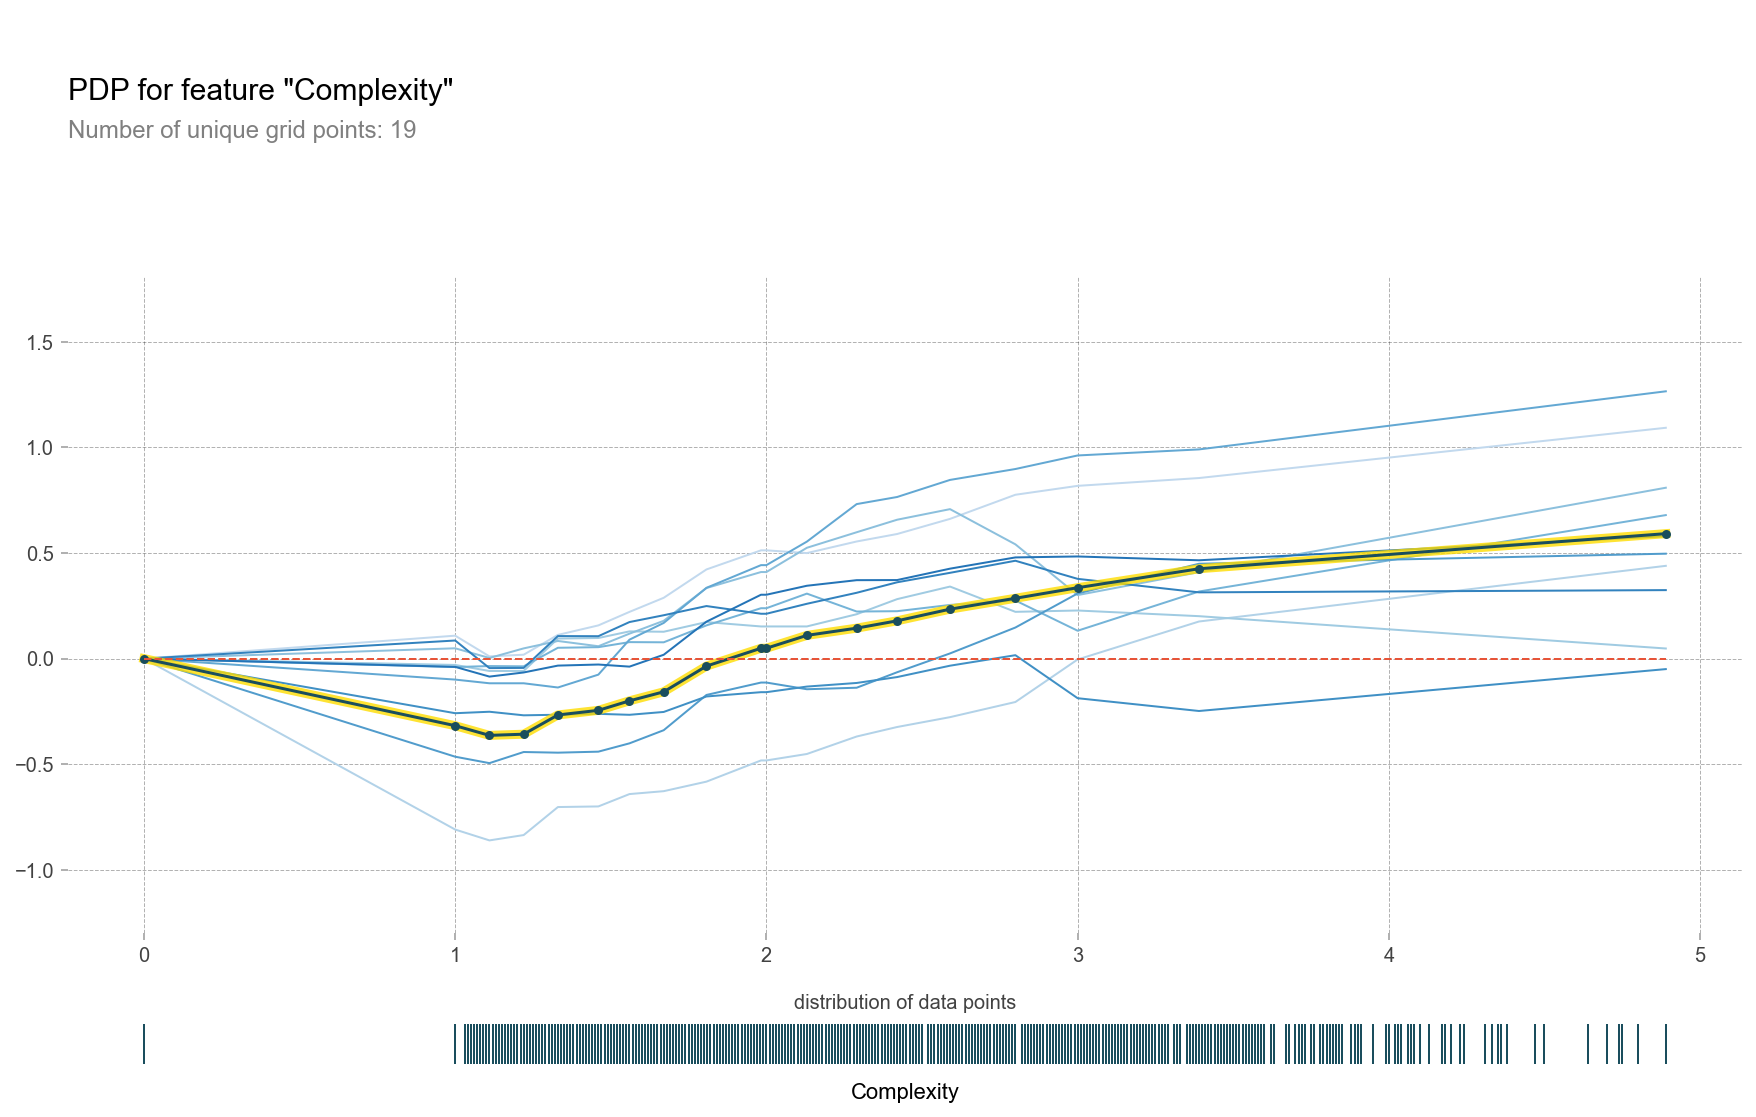

In [23]:
get_iso_pdp_plot("Complexity", best_xgb_, Xs['val'])

In [41]:
test_size = 0.2
random_state = 42
target_ = "Complexity"
unused_feature_list_ = ["Own", "Users_rated"]

In [42]:
def get_Xs_Ys(df, target = target_, exclude = unused_feature_list_, use_val=True):

      assert type(exclude) == list, "exclude must be list"

      train, test = train_test_split(
                        df,
                        test_size = test_size,
                        random_state = random_state)
      if use_val:
            train, val = train_test_split(
                              train,
                              test_size = test_size,
                              random_state = random_state)


      get_y = lambda data : data[target]
      get_x = lambda data : data.drop(columns = [target] + exclude)

      Ys = {"train" : get_y(train),
            "test" : get_y(test)}
      Xs = {"train" : get_x(train),
            "test" : get_x(test)}
      
      if use_val:
            Ys['val'] = get_y(val)
            Xs['val'] = get_x(val)
            
      return Xs, Ys

In [43]:
dataset = [df_, df_v1, df_v2, df_v3]
# dataset = [df_]

best_params_group = []
trials_group = []

for data in dataset:
    best_params, trials = find_best_param_xgb(data, results= True)
    best_params_group.append(best_params)
    trials_group.append(trials)

100%|██████████| 10/10 [00:07<00:00,  1.29trial/s, best loss: 0.19551422908006527]


In [44]:
Xs, Ys = get_Xs_Ys(df_)
# Xs, Ys = get_Xs_Ys(df)
best_xgb = make_best_model(best_params_group[0], Xs, Ys)


In [45]:
test_eval(Xs['test'], Ys['test'], best_xgb)

,MSE,RMSE,MAE,R2
Complexity,0.201366,0.448738,0.315738,0.712621


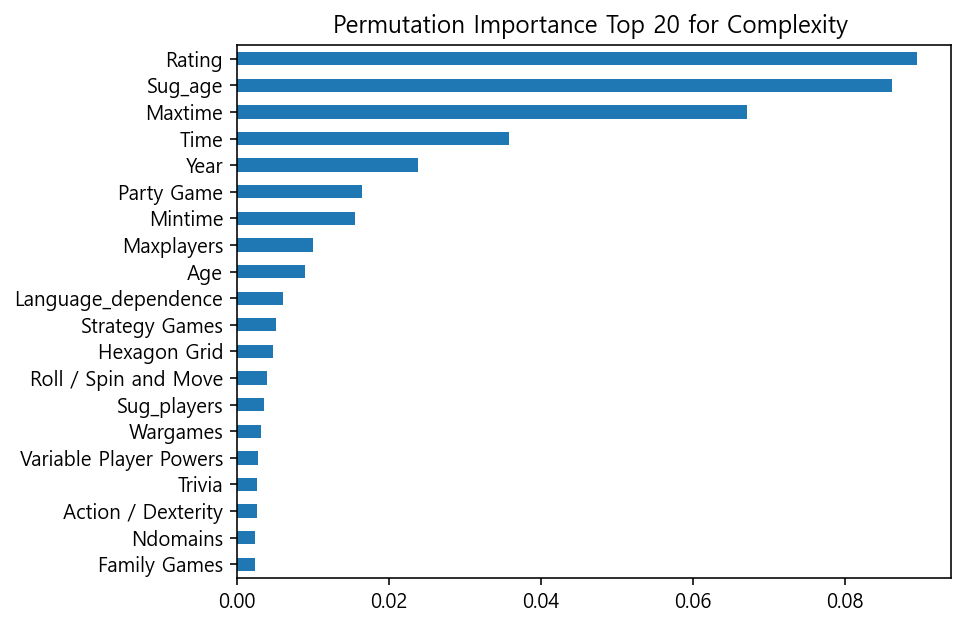

In [46]:
features = perm_imp(best_xgb, Xs['val'], Ys['val'], results=True)

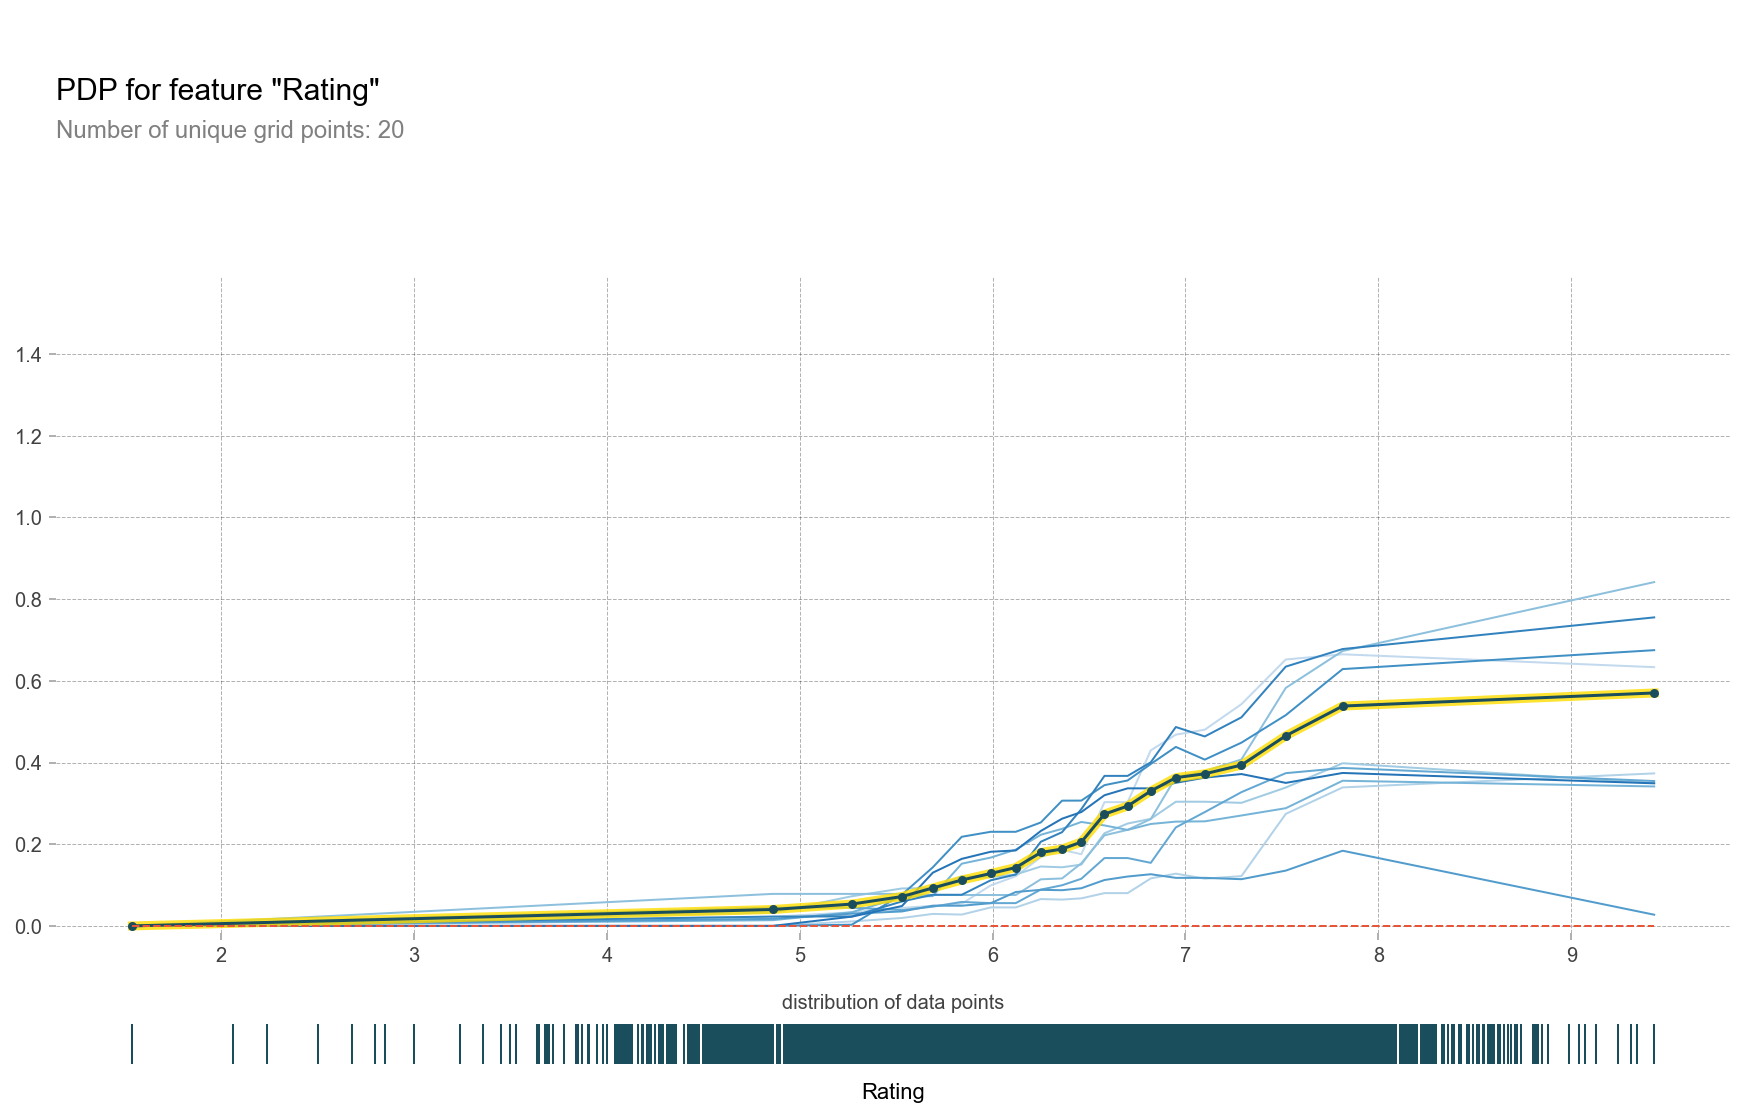

In [47]:
get_iso_pdp_plot("Rating", best_xgb, Xs['val'])